In [1]:
%matplotlib inline


# Training a CNN Classifier

You have seen the concepts of convolution neural networks. Let's try to implement it.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## Training an linear image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. **Define a linear softmax classifer (your task)**

3. **Define a loss function (your task)**
4. **Train the classifer on the training data**
5. **Test the classifer on the test data**

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [2]:
#Homework 3: CNN Classifier
#Sourav Joshi


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 62441759.20it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



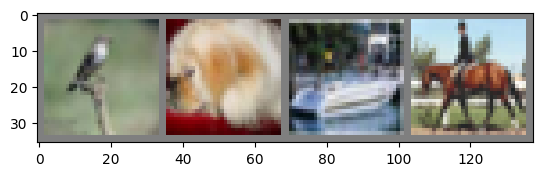

bird  dog   ship  horse


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define your CNN classifer
Define your CNN classfier here. (4 points)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# Define the model architecture
class Net(nn.Module):
   def __init__(self):
       super(Net, self).__init__()

       # Convolutional layers (feature extraction)
       # -----------------------------------------
       # Input: 3-channel images (assuming RGB format)
       self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 16 filters, 3x3 kernel, padding to preserve spatial dimensions
       self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 32 filters, 3x3 kernel

       # Max-pooling layer (downsampling)
       # -------------------------------
       self.pool = nn.MaxPool2d(2, 2)  # Reduce spatial dimensions by a factor of 2

       # Fully connected layers (classification)
       # ----------------------------------------
       # Assuming input image size is 32x32 after max-pooling
       self.fc1 = nn.Linear(32 * 8 * 8, 128)
       self.fc2 = nn.Linear(128, 10)  # Output 10 classes for CIFAR-10

   def forward(self, x):
       # Feature extraction through convolutional layers
       # -----------------------------------------------
       x = self.pool(F.relu(self.conv1(x)))  # ReLU activation after first convolution
       x = self.pool(F.relu(self.conv2(x)))  # ReLU activation after second convolution

       # Flatten the output for fully connected layers
       # ------------------------------------------
       x = x.view(-1, 32 * 8 * 8)

       # Classification through fully connected layers
       # ------------------------------------------
       x = F.relu(self.fc1(x))  # ReLU activation after first dense layer
       x = self.fc2(x)  # No activation for final output (logits)
       return x

# Instantiate the model
net = Net()  # Create an instance of the defined CNN architecture


### 3. Define a Loss function and optimizer
For example, let's use a Classification Cross-Entropy loss and SGD with momentum. Notice that if you need to use different loss functions.



In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the classifier

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
classifier and optimize.



In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.997
[1,  4000] loss: 1.603
[1,  6000] loss: 1.456
[1,  8000] loss: 1.367
[1, 10000] loss: 1.266
[1, 12000] loss: 1.204
[2,  2000] loss: 1.119
[2,  4000] loss: 1.103
[2,  6000] loss: 1.060
[2,  8000] loss: 1.025
[2, 10000] loss: 0.985
[2, 12000] loss: 0.994
Finished Training


Let's quickly save our trained model:



In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the classifier on the test data

We have trained the classifier for 2 passes over the training dataset.
But we need to check if the classifier has learnt anything at all.

We will check this by predicting the class label that the classifier
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



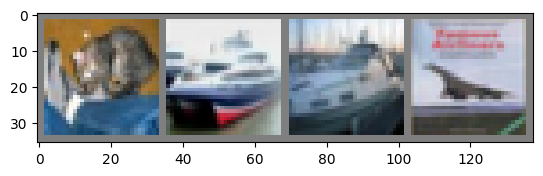

GroundTruth:  cat   ship  ship  plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the classifier thinks these examples above are:



In [12]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the classifier
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 




Let us look at how the classifier performs on the whole dataset.



In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the classifier
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the classifier on the 10000 test images: {100 * correct // total} %')

Accuracy of the classifier on the 10000 test images: 65 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the classifier learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')




Accuracy for class: plane is 68.9 %
Accuracy for class: car   is 80.9 %
Accuracy for class: bird  is 52.0 %
Accuracy for class: cat   is 29.1 %
Accuracy for class: deer  is 66.9 %
Accuracy for class: dog   is 62.9 %
Accuracy for class: frog  is 81.9 %
Accuracy for class: horse is 64.3 %
Accuracy for class: ship  is 82.6 %
Accuracy for class: truck is 70.3 %


Compare the results of linear classifier and CNN classifier:
1. Please plot the training losses of linear classifier and CNN classifier (3 points)
2. Show the test accuracy of linear classifer and CNN classifier (3 points)

In [16]:
#The Training losses and accuracies are shown below

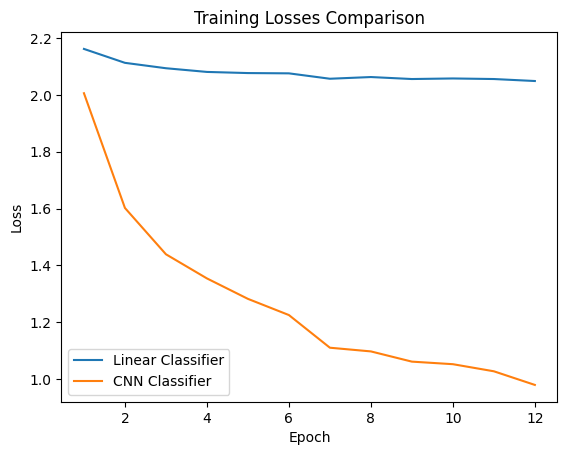

In [17]:
import matplotlib.pyplot as plt

# Training losses for the linear classifier
# These values are taken from Homework 2
linear_model_losses = [
    2.162, 2.113, 2.094, 2.081, 2.077, 2.076, 2.057, 2.063, 2.056, 2.058, 2.056, 2.049
]

# Training losses for the CNN classifier
cnn_model_losses = [
1.997, 1.603, 1.456, 1.367, 1.266, 1.204, 1.119, 1.103, 1.060, 1.025, 0.985, 0.994]

# List of epochs corresponding to the losses
epochs = range(1, len(linear_model_losses) + 1)

# Create the plot
plt.plot(epochs, linear_model_losses, label='Linear Classifier')
plt.plot(epochs, cnn_model_losses, label='CNN Classifier')

# labels and title
plt.title('Training Losses Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Legend to distinguish the lines
plt.legend()

# Display the plot
plt.show()


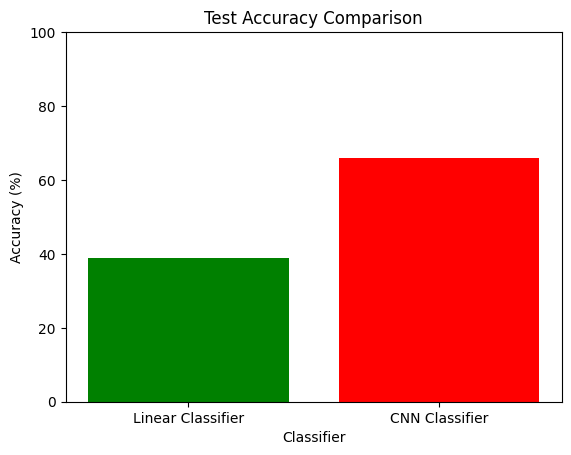

In [18]:
# Value taken from Homework 2.
# Accuracy of the linear classifier
linear_classifier_accuracy = 39

# accuracy of the CNN classifier as calculated above
cnn_classifier_accuracy = 100 * correct / total

# List of classifier labels for the bar chart
labels = ['Linear Classifier', 'CNN Classifier']

# List of accuracy values for each classifier
accuracies = [linear_classifier_accuracy, cnn_classifier_accuracy]

# Create a bar chart to compare accuracy
plt.bar(labels, accuracies, color=['green', 'red'])

# Set the title of the plot
plt.title('Test Accuracy Comparison')

# Set labels for the x-axis (classifier) and y-axis (accuracy)
plt.xlabel('Classifier')
plt.ylabel('Accuracy (%)')

# Set the y-axis limits to display the full range of accuracy (0-100%)
plt.ylim(0, 100)

# Display the plot
plt.show()


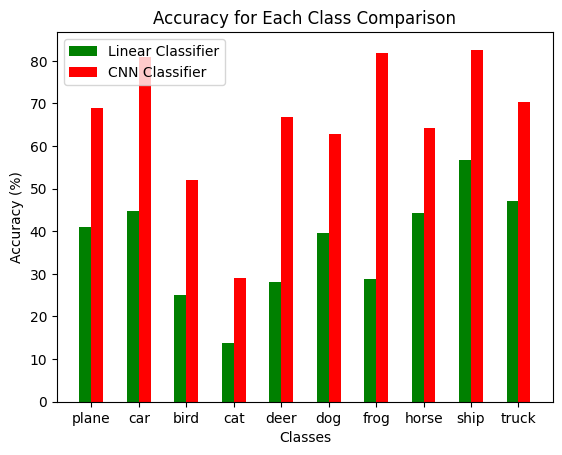

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# List of object class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Accuracy of the linear classifier for each class.
# Taken from Homework 2
linear_classifier_accuracies = [41.1, 44.7, 25.0, 13.7, 28.1, 39.6, 28.8, 44.4, 56.7, 47.0]

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Accuracy of the CNN classifier for each class
cnn_classifier_accuracies = [100 * float(correct_pred[classname]) / total_pred[classname] for classname in classes]

# Width of each bar in the chart
bar_width = 0.25

# Create an array of indices for the x-axis (one for each class)
index = np.arange(len(classes))

# Create bar charts for each classifier's accuracy, side-by-side
plt.bar(index, linear_classifier_accuracies, bar_width, label='Linear Classifier', color='green')
plt.bar(index + bar_width, cnn_classifier_accuracies, bar_width, label='CNN Classifier', color='red')

# Set labels for the x and y axes
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')

# Set the title of the chart
plt.title('Accuracy for Each Class Comparison')

# Set x-axis tick marks and labels (class names) with appropriate positioning
plt.xticks(index + bar_width / 2, classes)

# Add a legend to distinguish the bars for each classifier
plt.legend()

# Display the generated bar chart
plt.show()

